In [1]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
import time
import datetime as dt
from binance.client import Client

In [2]:
api_key = "m7jNDBUawJqRlDapzSaYLlb5FxYO8ZBbmS9t1uexkTfZHyhcM19noOxFIKCk8rVy"
secret_key = "yKxu1VfwTQg7jzci9GqkByF5DW7G86BtvLsquQv9RPJmmYGUku6YtG4YhSUZc5WE"

In [3]:
client = Client(api_key=api_key, api_secret=secret_key)

In [ ]:
def get_history(symbol, interval, start, end = None):
    bars = client.get_historical_klines(symbol = symbol, interval = interval,
                                        start_str = start, end_str = end, limit = 1000)
    df = pd.DataFrame(bars)
    df["Date"] = pd.to_datetime(df.iloc[:,0], unit = "ms")
    df.columns = ["Open Time", "Open", "High", "Low", "Close", "Volume",
                  "Clos Time", "Quote Asset Volume", "Number of Trades",
                  "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()
    df.set_index("Date", inplace = True)
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors = "coerce")
    
    return df

In [ ]:
df = get_history(symbol = "'ETHUSDT'", interval = "1d", start = '2022-01-01')
df

In [ ]:
['BTCUSDT', 'LTCUSDT', 'ADAUSDT', 'DOTUSDT', 'ETHUSDT', 'MATICUSDT']


In [32]:
df = pd.read_csv("/Users/reinisfals/Desktop/CODEX/ETH_MATIC.csv",
                 parse_dates = ["Date"], index_col = "Date")

In [34]:
pdata = df[["ETH-USDT-1min.csv_Close", "MATIC-USDT-1min.csv_Close","ETH-USDT-1min.csv_Return", "MATIC-USDT-1min.csv_Return"]].copy()
pdata = pdata.loc['2022-06-18 10:05:00':'2022-06-18 13:05:00']
pdata.columns = ["ETH", "MATIC","ETHr", "MATICr"]
pdata.head()

,ETH,MATIC,ETHr,MATICr
Date,,,,
2022-06-18 10:05:00,996.85,0.366,-0.003668,-0.005435
2022-06-18 10:06:00,996.12,0.366,-0.000732,0.000000
2022-06-18 10:07:00,997.99,0.367,0.001877,0.002732
2022-06-18 10:08:00,997.74,0.367,-0.000251,0.000000
2022-06-18 10:09:00,1000.47,0.368,0.002736,0.002725


In [9]:
df = df[["Date", "ETH-USDT-1min.csv_Return", "MATIC-USDT-1min.csv_Return"]].copy()
df.columns = ["Date", "ETH", "MATIC"]
df

,Date,ETH,MATIC
0,2019-04-26 15:00:00,0.000000,0.000000
1,2019-04-26 15:01:00,0.000128,-0.176839
2,2019-04-26 15:02:00,-0.000256,0.123574
3,2019-04-26 15:03:00,0.000192,-0.016920
4,2019-04-26 15:04:00,0.000447,-0.036145
...,...,...,...
1650795,2022-06-18 13:05:00,0.001426,0.005540
1650796,2022-06-18 13:06:00,-0.000191,-0.002755
1650797,2022-06-18 13:07:00,-0.000863,0.000000
1650798,2022-06-18 13:08:00,-0.000914,0.002762


In [10]:
data = df[(df['Date'] > '2022-06-18 10:05:00') & (df['Date'] < '2022-06-18 13:05:00')]


## EDA


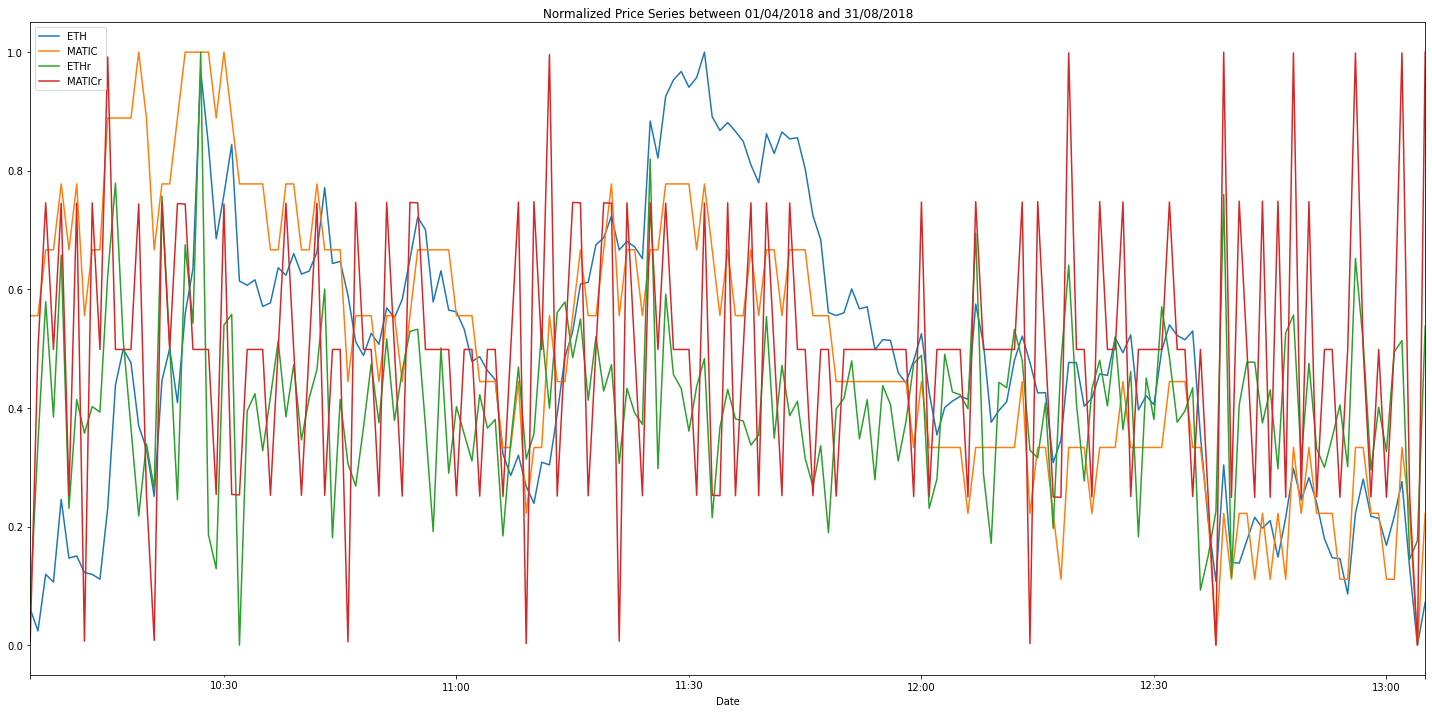

In [35]:
#I will make it pretty
import matplotlib.pyplot as plt
normalized_df=(pdata-pdata.min())/(pdata.max()-pdata.min()) # normalize the price series
normalized_df.plot(figsize=(25,12), title='Normalized Price Series between 01/04/2018 and 31/08/2018'); # Plot


## ADF


In [36]:
token_list = ['ETH', 'MATIC','ETHr', 'MATICr']

In [37]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import numpy as np

t_results_table = pd.DataFrame(columns=token_list, index=token_list) # Initizalize empty datafrane with token_list as both columns and indexes
p_results_table = pd.DataFrame(columns=token_list, index=token_list) # Initizalize empty datafrane with token_list as both columns and indexes

# Loop every column and every row
for row in token_list:
    for column in token_list:
        # If column is the same as row then set NaN as the result of the ADF test
        if row == column: 
            t_results_table[column][row] = np.nan
            p_results_table[column][row] = np.nan
        else: 
            regression = sm.OLS(pdata[row], sm.add_constant(pdata[column])).fit().params # Apply OLS     
            residual = pdata[row]-regression[1]*pdata[column]-regression[0] # Build the residual price series
            adf_results = adfuller(residual) # Calculate the ADF test on the residuals
            t_results_table[column][row] = adf_results[0] # Save the results to table
            p_results_table[column][row] = adf_results[1] # Save the results to table

In [38]:
t_results_table.head(len(token_list))#(if +2/-2 = significant

,ETH,MATIC,ETHr,MATICr
ETH,NaN,-2.519623,-1.702543,-2.12828
MATIC,-2.163637,NaN,-1.164134,-0.922878
ETHr,-13.542112,-10.884543,NaN,-7.171963
MATICr,-13.541823,-6.03424,-10.552691,NaN


In [ ]:
#Lets use 1st difference i.e. returns

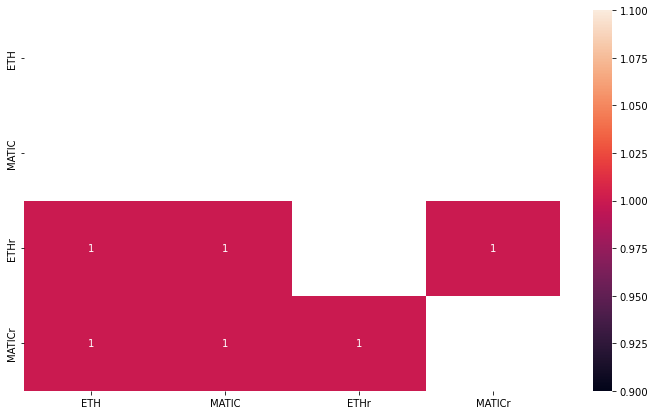

In [39]:
#will fix this
def tstat(cell):
    if cell < adf_results[4]['1%']:
        ret = 1
    elif cell < adf_results[4]['5%']:
        ret = 2
    else:
        ret = np.nan
    return ret

def convp(cell):
    if cell < 0.05:
        ret = 1
    else:
        ret = np.nan
    return ret

# Apply tstat function to every cell on table
tstat_table = t_results_table.applymap(tstat)
pvalue_table = p_results_table.applymap(convp)

results_table = pd.DataFrame(tstat_table.values*pvalue_table.values, columns=tstat_table.columns, index=tstat_table.index)

# Plot results with Seaborn
import seaborn as sns
fig = plt.figure(figsize=(12,7))
ax = sns.heatmap(results_table.values.astype(float), xticklabels = tstat_table.columns, yticklabels = tstat_table.columns, annot = True)


## Hurst Exponent


For random walk H = 0.5, for mean reverting H<0.5, for trending H>0.5

In [40]:
#need to fix
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn

def hurst(ts):
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

Hurst_results_table = pd.DataFrame(columns=token_list, index=token_list)

for row in token_list:
    for column in token_list:
        if row == column:
            Hurst_results_table[column][row] = np.nan
        else:
            regression = sm.OLS(pdata[row], sm.add_constant(pdata[column])).fit().params    
            residual = pdata[row]-regression[1]*pdata[column]-regression[0]
            hurst_results = hurst(residual)
            Hurst_results_table[column][row] = hurst_results
            

/var/folders/6f/p_mjrs9153ncg_04g6l8c2fr0000gn/T/ipykernel_87941/1266049811.py:12: RuntimeWarning: divide by zero encountered in log
  poly = polyfit(log(lags), log(tau), 1)


LinAlgError: SVD did not converge in Linear Least Squares

/Users/reinisfals/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/reinisfals/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


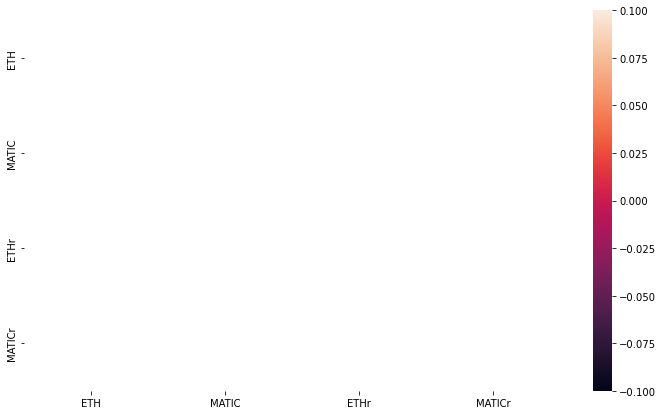

In [41]:
fig = plt.figure(figsize=(12,7))
ax = sns.heatmap(Hurst_results_table.values.astype(float), xticklabels = Hurst_results_table.columns, yticklabels = Hurst_results_table.columns, annot = True)


## Johansen test coming soon



## Cointegration


In [42]:
first = ['ETH','MATIC']
regression = sm.OLS(pdata['ETH'], sm.add_constant(pdata['MATIC'])).fit().params    
first_series = pdata['ETH']-regression[1]*pdata['MATIC']
title1 = (first[0] + ' - ' + str(np.around(regression[1], decimals=6)) + ' * ' + first[1])
first_pdata = pd.DataFrame(columns=[title1], index=pdata.index, data=first_series)

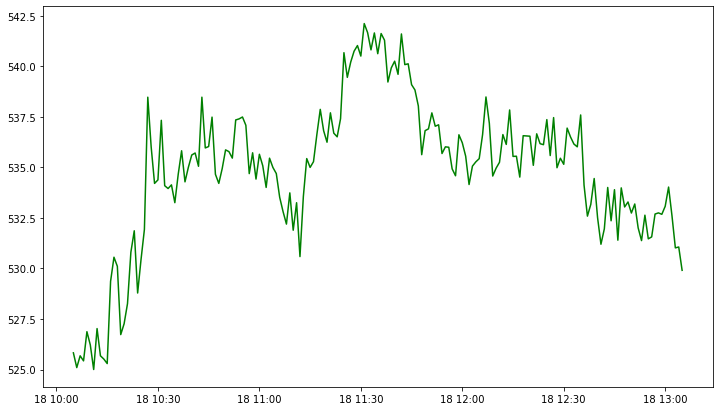

In [44]:
fig = plt.figure(figsize=(12,7))
plt.plot(first_series, color='green');

In [45]:
fir_adf = adfuller(first_series)
fir_hurst = hurst(first_series)
print('The Dickey-Fuller Test t-statistic is ' + str(np.around(fir_adf[0],4)) + ', which is smaller than the 1% critical value of ' + str(np.around(fir_adf[4]['1%'],4)))
print('The Dickey-Fuller Test p-value is ' + str(np.around(fir_adf[1],4)) + ', which is smaller than 0.05')
print('The Hurst Exponent value is ' + str(np.around(fir_hurst,4)) + ', which is much smaller than 0.5')

/var/folders/6f/p_mjrs9153ncg_04g6l8c2fr0000gn/T/ipykernel_87941/1266049811.py:12: RuntimeWarning: divide by zero encountered in log
  poly = polyfit(log(lags), log(tau), 1)


LinAlgError: SVD did not converge in Linear Least Squares